In [1]:
import os
import sys
from pathlib import Path
#for hpc
#notebook_dir = Path(os.getcwd()) / "AntiBERTa"
#for local device:
notebook_dir = Path(os.getcwd())
os.chdir(notebook_dir)

if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

print("New CWD:", os.getcwd())
print("Files here:", os.listdir())
print("sys.path includes notebook dir:", notebook_dir in map(Path, sys.path))


tok_dir = Path(os.getcwd()) / "tokenizer"
print("Tokenizer folder exists:", tok_dir.exists())
print("Contents:", list(tok_dir.iterdir()) if tok_dir.exists() else "N/A")
#works on hpc
#print("Files in module folder:", os.listdir(notebook_dir))

'''
remember to change kernelspec in HPC file to:
"kernelspec": {
    "display_name": "pytorch_env",
    "language": "python",
    "name": "pytorch_env"
  },

where pytorch_env is the conda environment with the required kernel and modules
'''


New CWD: c:\Users\felip\Documents\Thesis Language Learning\LanguageLearningModelsForAntigenPresentationPrediction\AntiBERTa
Files here: ['antibertaTrainHLAA0201.py', 'clustersAntiberta.ipynb', 'createROCs.ipynb', 'data', 'generatedPeptides', 'generatePeptides.py', 'hyperparamData', 'hyperparametricAnalysis.ipynb', 'hyperparamSearch.py', 'levenshteinDist.ipynb', 'lossAnalysis.py', 'metrics.ipynb', 'models', 'models3', 'modelsPeptideOnly', 'netmhcBenchmark', 'netmhcbenchmark.ipynb', 'quality.py', 'results', 'run5Fold.py', 'runSingleFold.py', 'script.py', 'test', 'tmp_output', 'tokenizer', 'TransmutModel', '__pycache__']
sys.path includes notebook dir: True
Tokenizer folder exists: True
Contents: [WindowsPath('c:/Users/felip/Documents/Thesis Language Learning/LanguageLearningModelsForAntigenPresentationPrediction/AntiBERTa/tokenizer/merges.txt'), WindowsPath('c:/Users/felip/Documents/Thesis Language Learning/LanguageLearningModelsForAntigenPresentationPrediction/AntiBERTa/tokenizer/vocab.

'\nremember to change kernelspec in HPC file to:\n"kernelspec": {\n    "display_name": "pytorch_env",\n    "language": "python",\n    "name": "pytorch_env"\n  },\n\nwhere pytorch_env is the conda environment with the required kernel and modules\n'

In [2]:
#focusing on allele HLA:A:02:01. Can change this for different hlas
hla_seq = "YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY"
modelName = "HLA_HLA-A_02-01"
generatedPeptFileName = "HLAA0201"
hlaName = "HLA-A:02:01"

In [ ]:
import matplotlib as plt
import torch
import random
import numpy as np
# we define a mix of fontsizes, for different parts of a plot
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

import seaborn as sns

# --- Consistent font sizes ---
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#setting seeds
seed = 6
random.seed(seed )
torch.manual_seed(seed )
np.random.seed(seed ) 
colours = ['#9BC995', "#083D77", '#9A031E', '#C4B7CB', '#FC7753']

# Create a seaborn palette from these colors
custom_palette = sns.color_palette(colours )
palette = sns.color_palette(custom_palette, n_colors=15)

In [4]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch
# Load tokenizer and model from correct directories
base = Path.cwd()  # should be /.../AntiBERTa
tok_path = base / "tokenizer"
model_path = base / "modelsPeptideOnly" /modelName

tokenizer = RobertaTokenizer.from_pretrained(tok_path,local_files_only=True)
model = RobertaForMaskedLM.from_pretrained(model_path, local_files_only=True) 
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(26, 768, padding_idx=1)
      (position_embeddings): Embedding(152, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-4): 5 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

#### Summarising probabilities with AUC

In [5]:
import pandas as pd 
from collections import Counter

df = pd.read_csv("data/fullData/data.csv")

In [ ]:
import os
import pandas as pd
import torch
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForMaskedLM
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn.functional as F

os.makedirs("results", exist_ok=True)

df = pd.read_csv("data/dataWithNegatives/eval_with_negatives.csv")

filtered_df = df[df["HLA_sequence"] == hla_seq] 

yTrue = []
yScores = []
peptideRecords = []

for _, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0], desc="Evaluating peptides"):
    peptide = row["peptide"]
    label = row["label"]

    # Tokenize peptide only
    peptide_tokens = tokenizer.tokenize(peptide)
    peptide_token_ids = tokenizer.convert_tokens_to_ids(peptide_tokens)
    L = len(peptide_token_ids)

    # Create base input with special tokens
    base_input_ids = [tokenizer.cls_token_id] + peptide_token_ids + [tokenizer.sep_token_id]

    log_probs = []

    for i in range(L):  # mask one token at a time (not left-to-right)
        masked_input = base_input_ids.copy()
        masked_input[i + 1] = tokenizer.mask_token_id

        input_ids = torch.tensor([masked_input], device=device)
        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits[0, i + 1]  # position of masked token
            log_probs_all = F.log_softmax(logits, dim=-1)

        true_token_id = peptide_token_ids[i]
        log_probs.append(log_probs_all[true_token_id].item())

    # Sum of log-probs = pseudo log-likelihood
    seq_log_prob = sum(log_probs)

    yTrue.append(label)
    yScores.append(seq_log_prob)
    peptideRecords.append((peptide, label, seq_log_prob))
# Compute and save AUC
auc = roc_auc_score(yTrue, yScores)
print(f"AUC for {hlaName}: {auc:.4f}")

# Save AUC
pd.DataFrame([{"HLA_name": hlaName, "AUC": auc}]).to_csv("results/fixed_hla_auc.csv", index=False)

# Save ROC curve
fpr, tpr, thresholds = roc_curve(yTrue, yScores)
pd.DataFrame({"FPR": fpr, "TPR": tpr, "Threshold": thresholds}).to_csv("results/fixed_hla_roc_curve.csv", index=False)

# Save peptide scores
peptide_rows = [{"Peptide": p, "Label": l, "LogProb": s} for p, l, s in peptideRecords]
pd.DataFrame(peptide_rows).to_csv("results/fixed_hla_peptide_scores.csv", index=False)

print("Done. Fixed-HLA evaluation complete.")

Evaluating peptides: 100%|██████████| 4248/4248 [07:58<00:00,  8.87it/s]


AUC for HLA-A:02:01: 0.8957
Done. Fixed-HLA evaluation complete.


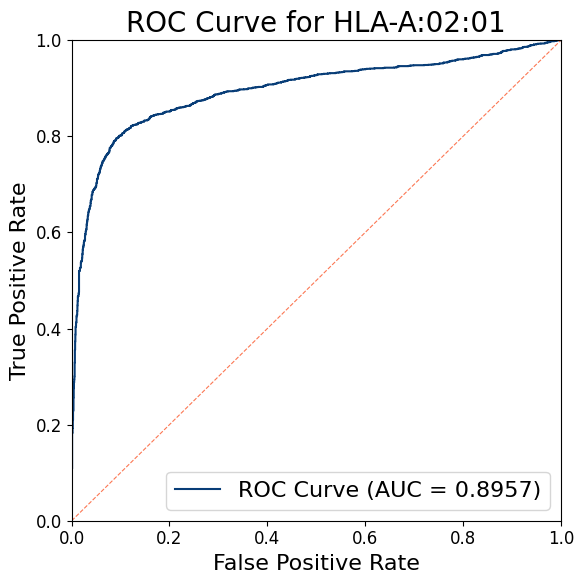

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("results/fixed_hla_roc_curve.csv")
auc_df = pd.read_csv("results/fixed_hla_auc.csv")
auc = auc_df.loc[0, "AUC"]
hla_name = auc_df.loc[0, "HLA_name"]

# Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(df["FPR"], df["TPR"], label=f"ROC Curve (AUC = {auc:.4f})", color=colours[1])
plt.plot([0, 1], [0, 1], linestyle='--', color=colours[4], linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for {hla_name}")
plt.legend(loc="lower right")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("results/fixed_hla_roc_curve.png", dpi=300)
plt.show()

In [9]:
import os
import pandas as pd
import torch
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForMaskedLM
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
import torch.nn.functional as F

os.makedirs("results", exist_ok=True)

df = pd.read_csv("data/dataWithNegatives/eval_with_negatives.csv")

filtered_df = df[df["HLA_sequence"] == hla_seq] 

yTrue = []
yScores = []
peptideRecords = []

for _, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0], desc="Evaluating peptides"):
    peptide = row["peptide"]
    label = row["label"]

    # Tokenize peptide only
    peptide_tokens = tokenizer.tokenize(peptide)
    peptide_token_ids = tokenizer.convert_tokens_to_ids(peptide_tokens)
    L = len(peptide_token_ids)

    # Create base input with special tokens
    base_input_ids = [tokenizer.cls_token_id] + peptide_token_ids + [tokenizer.sep_token_id]

    log_probs = []

    for i in range(L):  # mask one token at a time (PLL)
        masked_input = base_input_ids.copy()
        masked_input[i + 1] = tokenizer.mask_token_id

        input_ids = torch.tensor([masked_input], device=device)
        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits[0, i + 1]  # prediction at the masked position
            log_probs_all = F.log_softmax(logits, dim=-1)

        true_token_id = peptide_token_ids[i]
        log_probs.append(log_probs_all[true_token_id].item())

    # Sum of log-probs = pseudo log-likelihood
    seq_log_prob = sum(log_probs)

    yTrue.append(label)
    yScores.append(seq_log_prob)
    peptideRecords.append((peptide, label, seq_log_prob))

# Compute metrics
auc = roc_auc_score(yTrue, yScores)
aupr = average_precision_score(yTrue, yScores)

print(f"AUC for {hlaName}: {auc:.4f}")
print(f"AUPR for {hlaName}: {aupr:.4f}")

# Save AUC + AUPR
pd.DataFrame([{"HLA_name": hlaName, "AUC": auc, "AUPR": aupr}]).to_csv("results/fixed_hla_metrics.csv", index=False)

# Save ROC curve
fpr, tpr, thresholds = roc_curve(yTrue, yScores)
pd.DataFrame({"FPR": fpr, "TPR": tpr, "Threshold": thresholds}).to_csv("results/fixed_hla_roc_curve.csv", index=False)

# Save PR curve
precision, recall, thresholds = precision_recall_curve(yTrue, yScores)
pd.DataFrame({"Precision": precision, "Recall": recall, "Threshold": list(thresholds) + [None]}).to_csv("results/fixed_hla_pr_curve.csv", index=False)

# Save peptide scores
peptide_rows = [{"Peptide": p, "Label": l, "LogProb": s} for p, l, s in peptideRecords]
pd.DataFrame(peptide_rows).to_csv("results/fixed_hla_peptide_scores.csv", index=False)

print("Done. Fixed-HLA evaluation complete.")


Evaluating peptides: 100%|██████████| 4248/4248 [07:32<00:00,  9.39it/s] 

AUC for HLA-A:02:01: 0.8957
AUPR for HLA-A:02:01: 0.9154
Done. Fixed-HLA evaluation complete.


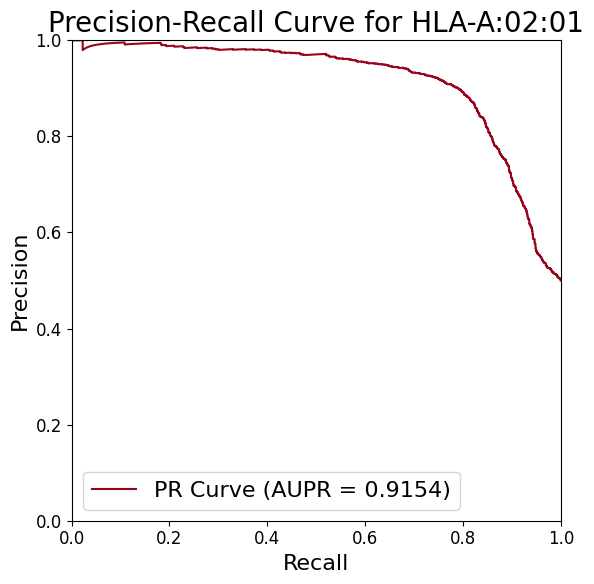

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load PR curve data
pr_df = pd.read_csv("results/fixed_hla_pr_curve.csv")
metrics_df = pd.read_csv("results/fixed_hla_metrics.csv")
aupr = metrics_df.loc[0, "AUPR"]
hla_name = metrics_df.loc[0, "HLA_name"]

colours = ['#9BC995', "#083D77", '#9A031E', '#C4B7CB', '#FC7753']

plt.figure(figsize=(6, 6))
plt.plot(pr_df["Recall"], pr_df["Precision"], label=f"PR Curve (AUPR = {aupr:.4f})", color=colours[2])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve for {hla_name}")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()

# Save + show
plt.savefig("results/fixed_hla_pr_curve.png", dpi=300)
plt.show()
